# 🗺️ Workshop 4 Network Analysis

**Universidad Nacional de Colombia**  
*Facultad de Ciencias Agrarias*  

**Presentado por:** María Fernanda López  

## 0. Introducción al análisis de redes

Las **redes** – o **grafos**, en términos matemáticos – ofrecen un marco poderoso para modelar y analizar relaciones entre entidades. En su forma más simple, un grafo consta de:

* **Nodos** (vértices): los objetos o entidades que participan en las relaciones (personas, ciudades, genes, etc.).
* **Aristas** (enlaces): las conexiones que unen pares de nodos y describen una relación específica (amistad, carretera, interacción biológica, etc.).

Tanto los nodos como las aristas pueden contener **metadatos** como pares clave–valor. Por ejemplo, en una red social los nodos “Hugo” y “Eric” podrían tener cada uno un atributo `{ "edad": 25 }`, mientras que la arista entre ellos podría guardar `{ "se_conocieron": "2016-05-21" }`.

### ¿Por qué modelar los datos como una red?
Representar los datos como un grafo permite abordar preguntas que son difíciles de responder con tablas convencionales, como por ejemplo:

* ¿Quiénes son los influenciadores clave dentro de una comunidad en línea?
* ¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?
* ¿Existen grupos o comunidades densamente conectadas en la red?

Encontrar el camino más corto usando una red vial específica es un problema común en los SIG (Sistemas de Información Geográfica) que tiene muchas aplicaciones prácticas. Por ejemplo, la navegación es una de esas aplicaciones en las que se utilizan algoritmos de ruteo para encontrar la mejor ruta entre dos o más puntos.

Al examinar la estructura de un grafo, podemos calcular métricas a nivel de nodo (por ejemplo, centralidad), identificar enlaces críticos o detectar agrupamientos naturales de comunidades.

En Python, la biblioteca NetworkX (importada como nx) ofrece una API intuitiva para crear, manipular y visualizar grafos en memoria.

[1, 2, 3]
[(1, 2)]


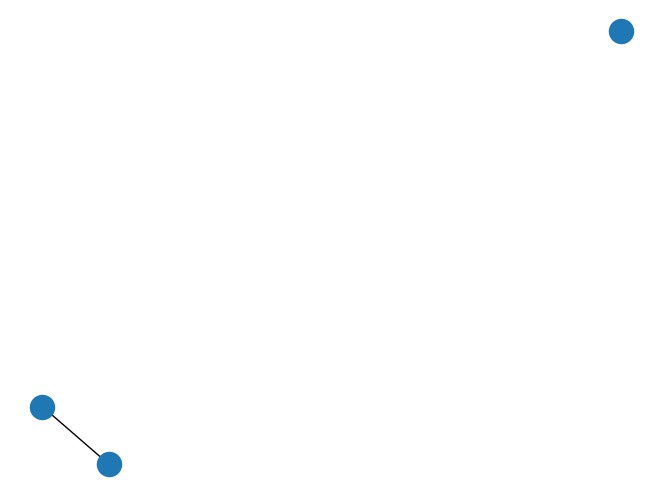

In [22]:
import networkx as nx

# Create an empty, undirected graph
G = nx.Graph()

# Add nodes and an edge
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspect nodes and edges
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Attach metadata
G.nodes[1]["label"] = "blue"

# Basic visualisation (requires matplotlib.pyplot as plt)
nx.draw(G)

El paquete [NetworkX](https://networkx.github.io/documentation/) proporciona diversas herramientas para analizar redes e implementa varios algoritmos de ruteo, como los algoritmos de [Dijkstra’s](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html) o [A\*](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.astar). Ambos son comúnmente utilizados para encontrar caminos más cortos en redes de transporte.

Para poder realizar un análisis de redes, es necesario, por supuesto, contar con una red sobre la cual hacer dicho análisis. El paquete OSMnx nos permite obtener redes enrutable desde OpenStreetMap para diferentes modos de transporte (a pie, en bicicleta o en automóvil). [OSMnx](https://osmnx.readthedocs.io/) también envuelve parte de la funcionalidad de NetworkX de forma conveniente para utilizarla con datos de OpenStreetMap.

En la siguiente sección, utilizaremos OSMnx para encontrar el camino más corto entre dos puntos basado en vías aptas para bicicletas. Con solo pequeñas modificaciones, podremos luego repetir el análisis sobre la red vial caminable.

## 1. Obtener una red enrutable

Para descargar datos de OpenStreetMap que representen la red vial, podemos usar la función
[`graph_from_place()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place)
de OSMnx. Esta función espera como parámetros un nombre de lugar y, de forma opcional, un tipo de red (por ejemplo, para caminar, andar en bicicleta o conducir).

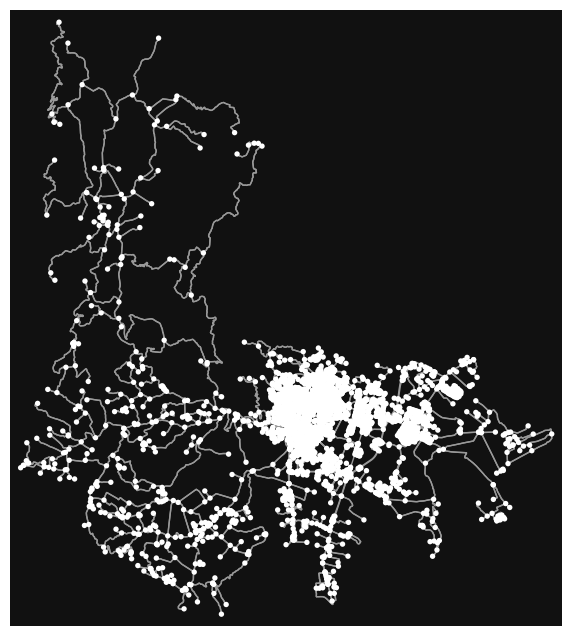

In [75]:
import osmnx

PLACE_NAME = "Zipaquirá, Colombia"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="bike"
)
figure, ax = osmnx.plot_graph(graph)

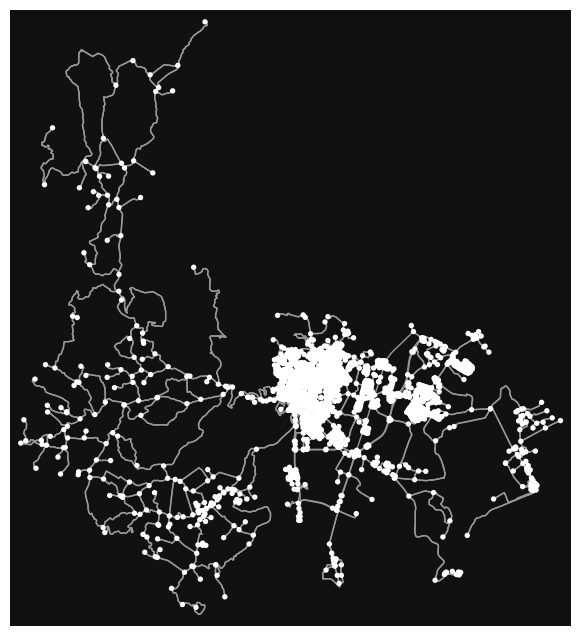

In [76]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:32618")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="drive"
)

fig, ax = osmnx.plot_graph(graph)

### 1.1. Visión general de los datos

Ahora que hemos obtenido un grafo completo de la red para el modo de viaje que especificamos (bicicleta), podemos examinar más de cerca qué atributos están asignados a los nodos y aristas (edges) de la red. Probablemente lo más sencillo sea convertir primero la red en un GeoDataFrame, sobre el cual podremos usar las herramientas que aprendimos en lecciones anteriores.

Para convertir un grafo en un GeoDataFrame, podemos usar la función `osmnx.graph_to_gdfs()` (ver [sección anterior](retrieve-data-from-openstreetmap)). En ella, podemos aprovechar los parámetros `nodes` y `edges` para seleccionar si queremos obtener solo los nodos, solo las aristas, o ambos (que es el valor por defecto).

In [81]:
nodes, edges = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
edges.head()

osmid      highway lanes  \
u          v          key                                              
260974465  277837885  0                  25498363    secondary     2   
           2805221430 0    [299136177, 904983085]    secondary     2   
277837885  277832350  0                  25498363    secondary     2   
2805221430 2805221431 0                 299136177    secondary     2   
260974525  260974640  0                 939085851  residential   NaN   

                           maxspeed  oneway  ref reversed      length  \
u          v          key                                               
260974465  277837885  0          80    True  45A    False   39.044984   
           2805221430 0    [60, 30]    True  NaN    False  246.524545   
277837885  277832350  0          80    True  45A    False   13.412443   
2805221430 2805221431 0          30    True  NaN    False   10.700408   
260974525  260974640  0         NaN    True  NaN    False  157.429424   

                                                                    geometry  \
u          v          key                                                      
260974465  277837885  0    LINESTRING (610325.782 553875.319, 610330.05 5...   
           2805221430 0    LINESTRING (610325.782 553875.319, 610334.844 ...   
277837885  277832350  0    LINESTRING (610327.378 553912.557, 610317.22 5...   
2805221430 2805221431 0    LINESTRING (610570.374 553888.559, 610581.084 ...   
260974525  260974640  0    LINESTRING (610305.695 554969.311, 610403.46 5...   

                                         name junction bridge access width  
u          v          key                                                   
260974465  277837885  0                   NaN      NaN    NaN    NaN   NaN  
           2805221430 0    Avenida Industrial      NaN    NaN    NaN   NaN  
277837885  277832350  0                   NaN      NaN    NaN    NaN   NaN  
2805221430 2805221431 0    Avenida Industrial      NaN    NaN    NaN   NaN  
260974525  260974640  0             Carrera 9      NaN    NaN    NaN   NaN

El GeoData resultante contiene una larga lista de columnas. La mayoría están relacionadas con las etiquetas de [OpenStreetMap tags](https://wiki.openstreetmap.org/wiki/Tags), y sus nombres son bastante autoexplicativos. Las columnas u y v describen la relación topológica dentro de la red: indican el nodo de inicio y el nodo de fin de cada arista.

| Columna                                                                | Descripción                         | Tipo de datos     |
|------------------------------------------------------------------------|-------------------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)                | Indica si es un puente              | boolean           |
| geometry                                                               | Geometría del elemento              | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)              | Tipo de vía (etiqueta de carretera) | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)                  | Número de carriles                  | int (or nan)      |
| [length](http://wiki.openstreetmap.org/wiki/Key:length)                | Longitud del elemento (en metros)   | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)            | Límite de velocidad legal máximo    | int / list        |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)                    | Nombre del elemento (ej. calle)     | str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)                | Indica si la vía es de un solo sentido| boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)                       | Identificador único del elemento    | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                                          | Nodo de inicio de la arista         | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                                          | Nodo de fin de la arista            | int               |


¿Qué tipos de calles componen nuestra red?

In [26]:
edges["highway"].value_counts()

highway
residential                    4527
unclassified                    586
secondary                       296
tertiary                        293
trunk                            50
primary                          39
trunk_link                       11
secondary_link                    5
[secondary_link, secondary]       1
primary_link                      1
Name: count, dtype: int64

### 1.2. Transformar a un sistema de referencia proyectado
El sistema de referencia cartográfico (CRS) de los datos de la red es WGS84 (EPSG:4326), un sistema de referencia geográfico. Esto significa que las distancias se registran y expresan en grados, y las áreas en grados cuadrados. Este sistema no es conveniente para análisis de redes, como encontrar la ruta más corta.

Una vez más, los objetos *graph* de OSMnx no ofrecen un método propio para transformar sus datos geográficos, pero OSMnx incluye una función separada: [`osmnx.project_graph()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph), que acepta un grafo de entrada y un CRS como parámetros, y devuelve un nuevo grafo transformado. Si no se especifica el parámetro `crs`, la transformación se hace por defecto a la zona UTM local más adecuada.

In [27]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 2. Análisis de propiedades de la red

Ahora que hemos preparado un grafo de red enrutable, podemos pasar a las funcionalidades más analíticas de OSMnx y extraer información sobre la red. Para calcular características básicas de la red, se puede usar la función [`osmnx.basic_stats()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats).

In [28]:
# Calculate network statistics
osmnx.basic_stats(graph)

{'n': 2333,
 'm': 5809,
 'k_avg': 4.979854264894985,
 'edge_length_total': 858944.8219334572,
 'edge_length_avg': 147.86448991796473,
 'streets_per_node_avg': 2.6999571367338193,
 'streets_per_node_counts': {0: 0, 1: 532, 2: 5, 3: 1429, 4: 365, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.22803257608229746,
  2: 0.0021431633090441492,
  3: 0.6125160737248179,
  4: 0.1564509215602229,
  5: 0.0008572653236176596},
 'intersection_count': 1801,
 'street_length_total': 457539.5673650387,
 'street_segment_count': 3133,
 'street_length_avg': 146.0388022231212,
 'circuity_avg': 1.141824237385944,
 'self_loop_proportion': 0.0012767315671879987}

Esto aún no nos da todas las características interesantes de nuestra red, ya que OSMnx no considera automáticamente el área cubierta por la red. Podemos hacer esto manualmente, primero delineando la envolvente [complex
hull](https://en.wikipedia.org/wiki/Convex_hull) (mediante una unión unaria de todas sus geometrías) y luego, en segundo lugar, calculando el área de dicha envolvente.

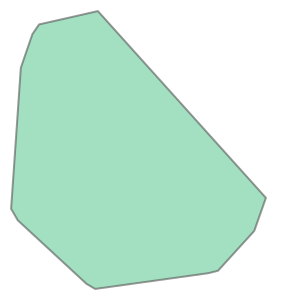

In [29]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [30]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 2333,
 'm': 5809,
 'k_avg': 4.979854264894985,
 'edge_length_total': 858944.8219334572,
 'edge_length_avg': 147.86448991796473,
 'streets_per_node_avg': 2.6999571367338193,
 'streets_per_node_counts': {0: 0, 1: 532, 2: 5, 3: 1429, 4: 365, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.22803257608229746,
  2: 0.0021431633090441492,
  3: 0.6125160737248179,
  4: 0.1564509215602229,
  5: 0.0008572653236176596},
 'intersection_count': 1801,
 'street_length_total': 457539.5673650387,
 'street_segment_count': 3133,
 'street_length_avg': 146.0388022231212,
 'circuity_avg': 1.141824237385944,
 'self_loop_proportion': 0.0012767315671879987,
 'node_density_km': 11.359264496544176,
 'intersection_density_km': 8.768982150997026,
 'edge_density_km': 4182.160917393562,
 'street_density_km': 2227.7380897273324}

### 2.1. 🚀 ¡Ahora te toca a ti! — Explorando atributos de las calles
1. **Calcula** la longitud total de las calles clasificadas como residential, primary y secondary.
2. **Compara** la longitud media de cada una de estas clases.
3. **Visualiza** las cinco clases de calles más largas en un gráfico de barras.

> 💡 *Sugerencia:* `edges.groupby("highway")["length"].sum()` seguido de `.sort_values()` te será de ayuda.

####  2.1.1 Calcular longitud total por clase (residential, primary, secondary)

In [31]:
# Filtrar por las clases de interés
selected_classes = ["residential", "primary", "secondary"]
lengths_total = edges[edges["highway"].isin(selected_classes)].groupby("highway")["length"].sum()
print("Longitud total por clase:\n", lengths_total)

Longitud total por clase:
 highway
primary         15381.403802
residential    355843.075935
secondary       63148.911287
Name: length, dtype: float64


#### 2.1.2 Calcular la longitud media por clase

In [32]:
mean_lengths = edges[edges["highway"].isin(selected_classes)].groupby("highway")["length"].mean()
print("Longitud media por clase:\n", mean_lengths)

Longitud media por clase:
 highway
primary        394.394969
residential     78.604611
secondary      213.340917
Name: length, dtype: float64


#### 2.1.3 Visualizar las 5 clases de calle más largas

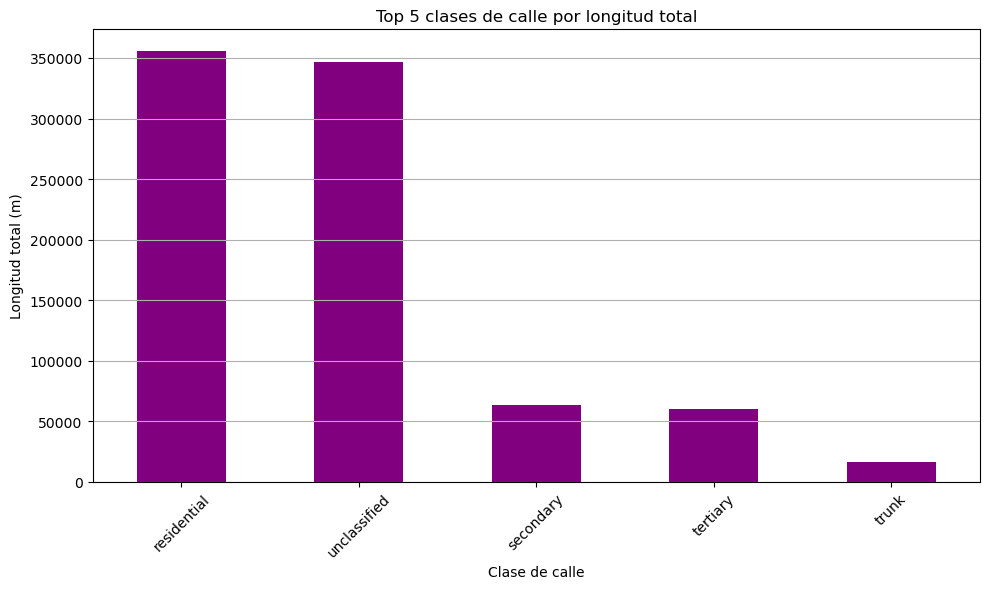

In [33]:
edges_exploded = edges.explode("highway")

edges_exploded["highway"] = edges_exploded["highway"].astype(str)

top5_classes = edges_exploded.groupby("highway")["length"].sum().sort_values(ascending=False).head(5)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top5_classes.plot(kind="bar", color="purple")
plt.title("Top 5 clases de calle por longitud total")
plt.xlabel("Clase de calle")
plt.ylabel("Longitud total (m)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [34]:
import math
import myst_nb

myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

11.4

858

Como podemos ver, ahora tenemos mucha información sobre nuestra red vial que puede ser utilizada para comprender su estructura. Por ejemplo, podemos observar que la densidad promedio de nodos en nuestra red es de {glue:}`node_density_km`&nbsp;nodos/km y que la longitud total de las aristas de la red supera los {glue:}`edge_length_total`&nbsp;kilómetros.

> **Nota: Medidas de centralidad**

> En años anteriores, este curso también abordaba la [centralidad de grado](https://en.wikipedia.org/wiki/Centrality). El cálculo de medidas de centralidad ha cambiado en [OSMnx notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb), y profundizar en ello estaría fuera del alcance de este curso. Por favor, consulta el notebook de OSMnx para ver un ejemplo.

## 3. Análisis del camino más corto

Ahora vamos a calcular el camino más corto entre dos puntos usando [`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

### 3.1. Puntos de origen y destino

Primero necesitamos especificar los puntos de origen y destino para nuestra ruta. Si estás familiarizado con la zona de Kamppi, puedes indicar un nombre de lugar personalizado como punto de origen. O bien, puedes seguir el ejemplo y elegir los siguientes puntos como origen y destino en el análisis:

- [`"Maria 01, Helsinki"`](https://nominatim.openstreetmap.org/ui/search.html?q=Maria+01): un centro de startups ubicado en un antiguo hospital.
- [`"ruttopuisto"`](https://nominatim.openstreetmap.org/ui/search.html?q=ruttopuisto), un parque. Su nombre oficial es Vanha kirkkopuisto, pero Nominatim también puede geocodificar el apodo.

Podríamos obtener las coordenadas de estos lugares manualmente y crear objetos Point de `shapely.geometry.Point` basados en esas coordenadas. Sin embargo, si tuviéramos más de dos puntos, eso se volvería tedioso rápidamente. En su lugar, podemos usar OSMnx para geocodificar los lugares.

Recuerda transformar los puntos de origen y destino al mismo sistema de referencia que los datos de la red.

In [35]:
origin = (
    osmnx.geocode_to_gdf("Catedral de Sal, Zipaquirá, Cundinamarca")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("Zipaquirá, Cundinamarca")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

Ahora tenemos objetos `shapely.geometry.Point` que representan los lugares de origen y destino para nuestro análisis de red. En el siguiente paso, necesitamos ubicar estos puntos dentro de la red enrutable antes de realizar el enrutamiento final.

### 3.2. Nodo más cercano

Para poder trazar una ruta en la red, primero debemos encontrar un punto de inicio y un punto final que formen parte de la red. Para ello, usamos la función [`osmnx.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes), que devuelve el ID del nodo más cercano.

In [36]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

1317233811

In [37]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

960495241

### 3.3. Enrutamiento

Ahora estamos listos para realizar el enrutamiento y encontrar el camino más corto entre los puntos de origen y destino. Utilizaremos la función [`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

Esta función acepta tres parámetros obligatorios: un grafo, el ID del nodo de origen y el ID del nodo de destino. También acepta dos parámetros opcionales: `weight`, que puede establecerse para considerar un *costo distinto* a la longitud del trayecto, y `cpus`, que controla la computación paralela cuando se calculan muchas rutas.

In [38]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[1317233811,
 960716276,
 1317282610,
 260974623,
 260974611,
 1317234061,
 1317233815,
 960542329,
 960540365,
 648801770,
 648801776,
 9393916327,
 960542227,
 7616266285,
 960541754,
 6291625535,
 960537724,
 960539436,
 960540581,
 6178211086,
 960541929,
 960539993,
 960541977,
 960538763,
 960539363,
 960538218,
 960538522,
 5226821263,
 960542752,
 7616315773,
 8421593811,
 960538418,
 960542554,
 960539307,
 960494589,
 960494289,
 960494581,
 960495241]

Como resultado, obtenemos una lista con todos los nodos que forman parte del camino más corto.

Podríamos extraer las ubicaciones de esos `nodos` desde el GeoDataFrame de nodos y crear una representación tipo LineString con esos puntos, pero por suerte, OSMnx puede hacer eso por nosotros y podemos graficar el camino más corto usando la función `plot_graph_route()`.

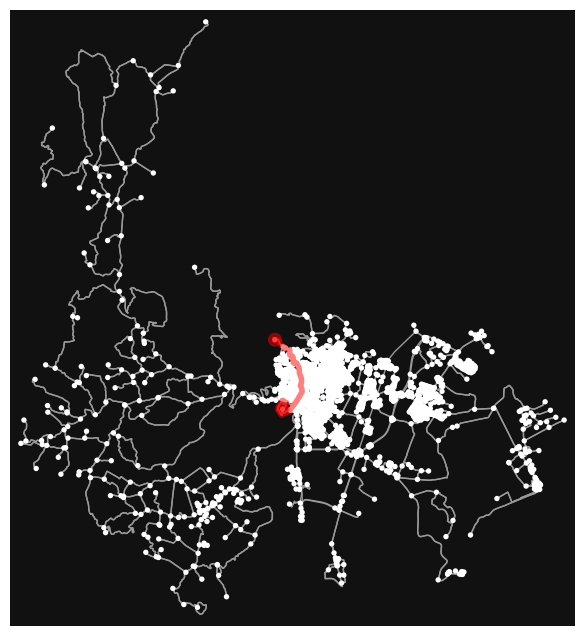

In [39]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

### 3.4. 🚀 ¡Ahora te toca a ti! — Rutas alternativas
1. **Calcula** una segunda ruta que evite las calles clasificadas como `motorway` y `trunk`.
2. **Compara** su longitud con la de la ruta más corta original.
3. **Discuta** en una sola frase, por qué las rutas con restricciones pueden ser útiles para ciertos usuarios.

#### 3.4.1 Calcular la ruta más corta original 

In [41]:
import osmnx as ox
import networkx as nx
import pandas as pd

# 1. Cargar grafo y convertir a GeoDataFrames
graph = ox.graph_from_place("Zipaquirá, Colombia", network_type="drive")
graph_proj = ox.project_graph(graph)
nodes, edges = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

# 2. Calcular la ruta original entre el centroide y el nodo más al este

# Centroide como origen
centroid = edges.geometry.union_all().convex_hull.centroid
orig_node = ox.distance.nearest_nodes(graph_proj, centroid.x, centroid.y)

# Nodo más al este como destino
nodes["x"] = nodes["x"].astype(float)
maxx = nodes["x"].max()
target_geom = nodes.loc[nodes["x"] == maxx, "geometry"].values[0]
dest_node = ox.distance.nearest_nodes(graph_proj, target_geom.x, target_geom.y)

# Ruta original
route = nx.shortest_path(graph_proj, orig_node, dest_node, weight="length")

# Función para calcular longitud de una ruta
def route_len(G, r):
    return sum(G[u][v][0]["length"] for u, v in zip(r[:-1], r[1:]))

# Calcular longitud de la ruta original
original_km = route_len(graph_proj, route) / 1000

# 3. Filtrar aristas para evitar motorway y trunk
ban = {"motorway", "trunk"}

def is_good_highway(hw, banned_tags):
    if not isinstance(hw, list):
        hw = [hw]
    return all(tag not in banned_tags for tag in hw)

mask_values = [is_good_highway(hw, ban) for hw in edges["highway"]]
mask_good = pd.Series(mask_values, index=edges.index)
alt_edges = edges[mask_good].copy()

# 4. Crear grafo alternativo sin motorway ni trunk
G_alt = ox.graph_from_gdfs(nodes, alt_edges, graph_attrs=graph_proj.graph)

# 5. Buscar ruta alternativa garantizando conexión
if nx.has_path(G_alt, orig_node, dest_node):
    # Si están conectados directamente
    route_alt = nx.shortest_path(G_alt, orig_node, dest_node, weight="length")
else:
    # Buscar componente del nodo origen
    component = nx.node_connected_component(G_alt.to_undirected(), orig_node)

    # Encontrar nodo más cercano al destino original dentro del mismo componente
    closest_node = min(component, key=lambda node: graph_proj.nodes[node]['x'] - target_geom.x if 'x' in graph_proj.nodes[node] else float('inf'))
    
    if closest_node == orig_node:
        print("Solo hay un nodo en el componente, imposible generar ruta alternativa.")
        route_alt = None
    else:
        route_alt = nx.shortest_path(G_alt, orig_node, closest_node, weight="length")
        print("Nodo destino original no conectado. Se usó nodo alternativo más cercano.")

# Si se encontró una ruta alternativa válida
if route_alt:
    alt_km = route_len(G_alt, route_alt) / 1000
    diff_km = alt_km - original_km

    print(f"Ruta original: {original_km:.2f} km")
    print(f"Ruta alternativa (sin motorway/trunk): {alt_km:.2f} km")
    print(f"Diferencia: {diff_km:.2f} km")
    print("Las rutas con restricciones son útiles para ciclistas, peatones o vehículos que no pueden circular por autopistas.")
else:
    print(f"Ruta original: {original_km:.2f} km")
    print("No se pudo encontrar ninguna ruta alternativa útil.")

Nodo destino original no conectado. Se usó nodo alternativo más cercano.
Ruta original: 12.00 km
Ruta alternativa (sin motorway/trunk): 13.89 km
Diferencia: 1.88 km
Las rutas con restricciones son útiles para ciclistas, peatones o vehículos que no pueden circular por autopistas.


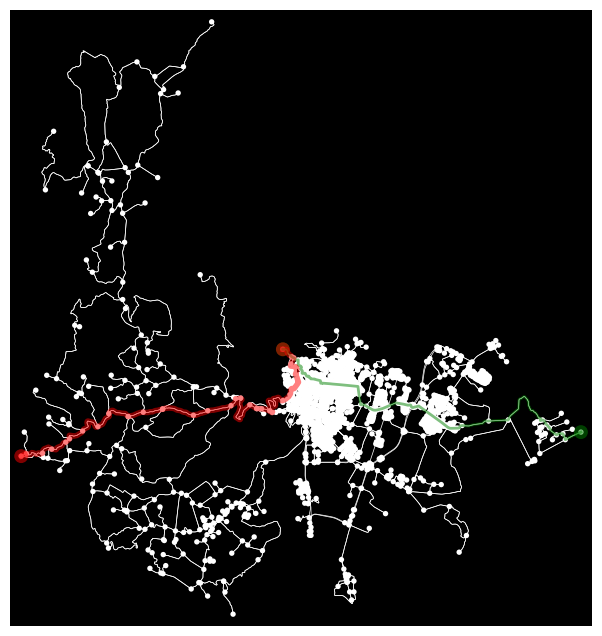

In [42]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(
    graph_proj,
    bgcolor="black",          
    node_color="white",       
    node_size=15,
    edge_color="white",       
    edge_linewidth=0.5,
    show=False, close=False   
)

if route:
    ox.plot_graph_route(
        graph_proj,
        route,
        route_color="green",
        route_linewidth=2,
        ax=ax,
        show=False,
        close=False
    )

if route_alt:
    ox.plot_graph_route(
        graph_proj,
        route_alt,
        route_color="red",
        route_linewidth=4,
        ax=ax,
        show=True,  
        close=True
    )

En este ejercicio se realizó un análisis de rutas dentro de la red vial de Zipaquirá, Colombia. Primero, se construyó un grafo enrutable del tipo “drive” y lo se proyectó a un sistema de coordenadas adecuado para análisis métricos. A partir de ese grafo, se identificaron como punto de origen el centroide del área urbana (calculado a partir del convex hull de las aristas), y como destino el nodo ubicado más al este dentro de la red.

Una vez definidos los puntos de partida y llegada, se calculó la ruta más corta entre ellos utilizando el algoritmo de Dijkstra y se midió su longitud en kilómetros. Posteriormente, se filtraron las aristas de la red para eliminar aquellas clasificadas como motorway o trunk, es decir, autopistas y vías principales, con el fin de construir una red alternativa que represente rutas más accesibles o seguras para usuarios como ciclistas o peatones.

Luego, se verificó si el nodo de origen y el de destino seguían conectados dentro de esta red filtrada. Si no lo estaban, se buscó dentro del mismo componente conexo un nodo alternativo al destino original que estuviera lo más cerca posible. Finalmente, se calculó la nueva ruta alternativa (si fue posible) y comparamos su longitud con la ruta original. Esto permitió visualizar el impacto de evitar ciertas categorías viales y reflexionar sobre cómo las rutas restringidas pueden beneficiar a ciertos tipos de usuarios.

### 3.5 Usar el algoritmo A*

In [112]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 1. Identifica la geometría del centroide
centroid = edges.geometry.union_all().centroid  # puedes ignorar el warning

# 2. Encuentra el tramo de la ruta original más cercano al centroide
min_dist = float("inf")
segment_to_block = None
for u, v in zip(route[:-1], route[1:]):
    edge_data = graph_proj.get_edge_data(u, v)[0]
    geom = edge_data.get("geometry")
    if geom:
        dist = geom.distance(centroid)
        if dist < min_dist:
            min_dist = dist
            segment_to_block = (u, v, 0)

# 3. Crear grafo modificado sin ese tramo
graph_blocked = graph_proj.copy()
u, v, k = segment_to_block
if graph_blocked.has_edge(u, v, k):
    graph_blocked.remove_edge(u, v, k)

# 4. Ejecutar A* sobre el grafo modificado
try:
    def euclidean_heuristic(u, v):
        x1, y1 = graph_blocked.nodes[u]["x"], graph_blocked.nodes[u]["y"]
        x2, y2 = graph_blocked.nodes[v]["x"], graph_blocked.nodes[v]["y"]
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    route_astar = nx.astar_path(graph_blocked, orig_node, dest_node, heuristic=euclidean_heuristic, weight="length")
    astar_km = route_len(graph_blocked, route_astar) / 1000
    diff_km = astar_km - original_km

    print(f"📏 Dijkstra: {original_km:.2f} km")
    print(f"⭐ A*: {astar_km:.2f} km")
    print(f"📊 Diferencia: {diff_km:.2f} km")
except nx.NetworkXNoPath:
    print("❌ No se pudo encontrar una ruta alternativa con A* tras bloquear el segmento más cercano al centro.")

📏 Dijkstra: 12.00 km
⭐ A*: 11.33 km
📊 Diferencia: -0.68 km


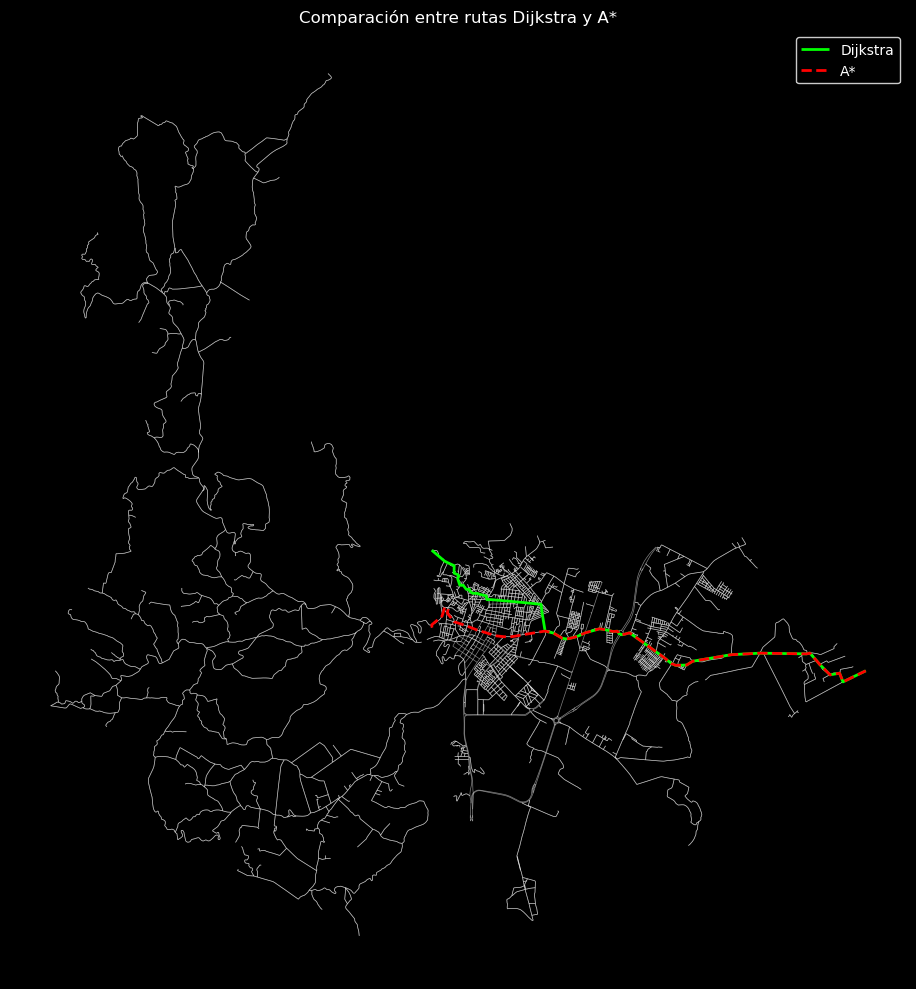

In [114]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import geopandas as gpd

# Función para convertir la ruta en geometría LineString
def route_to_linestring(G, route):
    coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in route]
    return LineString(coords)

# Crear geometrías
line_dijkstra = route_to_linestring(graph_proj, route)
line_astar = route_to_linestring(graph_blocked, route_astar)

# Crear GeoDataFrame
routes_gdf = gpd.GeoDataFrame({
    'name': ['Dijkstra', 'A*'],
    'length_km': [original_km, astar_km]
}, geometry=[line_dijkstra, line_astar], crs=edges.crs)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')  # 👈 fondo general
ax.set_facecolor('black')  # 👈 fondo dentro del área de dibujo

edges.plot(ax=ax, linewidth=0.5, color='white', alpha=0.5)  # calles en blanco
routes_gdf[routes_gdf['name'] == 'Dijkstra'].plot(ax=ax, color='lime', linewidth=2, label='Dijkstra')
routes_gdf[routes_gdf['name'] == 'A*'].plot(ax=ax, color='red', linestyle='--', linewidth=2, label='A*')

ax.legend(facecolor='black', edgecolor='white', labelcolor='white')  # 👈 estilo oscuro para leyenda
ax.set_title("Comparación entre rutas Dijkstra y A*", color='white')
plt.axis("off")
plt.tight_layout()
plt.show()

Durante el análisis de rutas en Zipaquirá, inicialmente se intentó comparar los resultados de los algoritmos Dijkstra y A*, pero ambos devolvían la misma ruta al usar la longitud como peso. Se probaron diversas estrategias para forzar una diferencia, como penalizar por velocidad (maxspeed), modificar pesos en aristas o nodos, y eliminar calles mediante buffers, pero estos enfoques fallaban por datos faltantes o porque el grafo resultaba desconectado. La solución definitiva consistió en identificar y eliminar del grafo original el tramo más cercano al centroide dentro de la ruta Dijkstra, lo cual obligó a A* a tomar un camino diferente.

## 4. Guardar los caminos más cortos en disco

Muy a menudo se necesita guardar la ruta en un archivo para realizar análisis posteriores o propósitos de visualización, o al menos tenerla como un objeto GeoDataFrame en Python. Por lo tanto, sigamos un poco más y veamos cómo podemos convertir la ruta en una LineString y guardar la geometría del camino más corto junto con sus atributos relacionados en un archivo GeoPackage.

Primero, necesitamos obtener los nodos que pertenecen al camino más corto:

In [43]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,highway,junction,railway,geometry
osmid,,,,,,,
960495241,557313.138640,609621.752205,1,NaN,NaN,NaN,POINT (609621.752 557313.139)
960494581,557089.927046,609883.497821,3,NaN,NaN,NaN,POINT (609883.498 557089.927)
960494289,557053.835694,609952.199960,3,NaN,NaN,NaN,POINT (609952.2 557053.836)
960494589,556992.782731,610087.414580,3,NaN,NaN,NaN,POINT (610087.415 556992.783)
960539307,556881.605402,610085.510644,4,NaN,NaN,NaN,POINT (610085.511 556881.605)
...,...,...,...,...,...,...,...
7623617367,554941.368548,617679.711615,3,NaN,NaN,NaN,POINT (617679.712 554941.369)
7623617363,554725.188654,617893.776099,3,NaN,NaN,NaN,POINT (617893.776 554725.189)
7629623443,554759.253037,618092.023867,3,NaN,NaN,NaN,POINT (618092.024 554759.253)


Como podemos ver, ahora tenemos todos los nodos que formaron parte del camino más corto como un GeoDataFrame.

Ahora podemos crear un LineString a partir de las geometrías Point de los nodos:

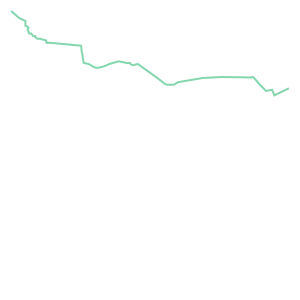

In [44]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

Ahora tenemos la ruta como una geometría LineString.

Vamos a crear un GeoDataFrame a partir de ella, incluyendo información útil sobre la ruta, como una lista de los osmid que forman parte del recorrido y la longitud total del trayecto.

In [45]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (609621.752 557313.139, 609883.498 ...","[960495241, 960494581, 960494289, 960494589, 9...",10885.96309


Ahora tenemos un GeoDataFrame que podemos guardar en disco. Vamos a confirmar que todo está correcto graficando nuestra ruta sobre la red vial y algunos edificios, y también dibujando los puntos de origen y destino sobre el mapa.

Descargar edificios:

In [46]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

Ahora vamos a graficar la ruta y los elementos de la red vial para verificar que todo esté como debería.

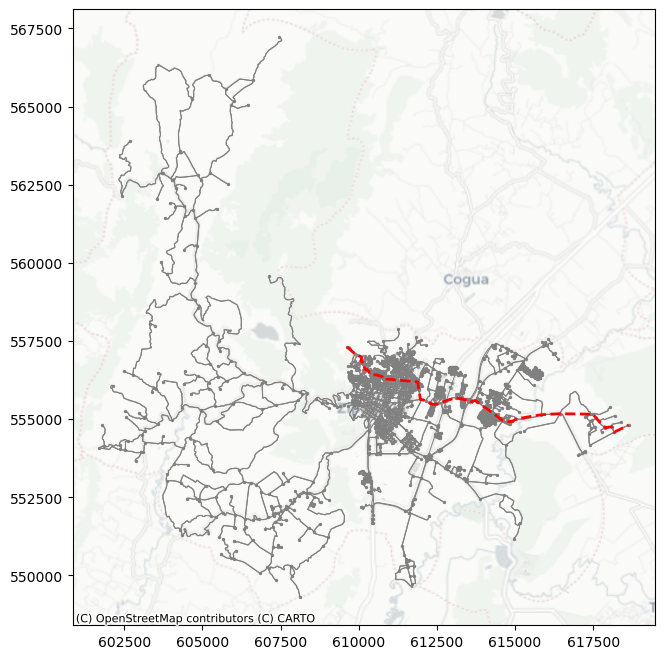

In [47]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

Como se puede ver, ahora se tiene control total sobre todos los elementos de nuestro mapa y se pueden utilizar todas las propiedades estéticas que ofrece matplotlib para modificar su apariencia.

### 4.1 Preparar los datos para guardarlos en un archivo

Los datos contienen ciertos tipos de datos (como `listas`) que deben convertirse en cadenas de texto antes de guardarlos en un archivo (una alternativa sería eliminar las columnas no válidas).

In [48]:
edges.head()

osmid      highway lanes  \
u          v          key                                              
260974465  277837885  0                  25498363    secondary     2   
           2805221430 0    [299136177, 904983085]    secondary     2   
277837885  277832350  0                  25498363    secondary     2   
2805221430 2805221431 0                 299136177    secondary     2   
260974525  260974640  0                 939085851  residential   NaN   

                           maxspeed  oneway  ref reversed      length  \
u          v          key                                               
260974465  277837885  0          80    True  45A    False   39.044984   
           2805221430 0    [60, 30]    True  NaN    False  246.524545   
277837885  277832350  0          80    True  45A    False   13.412443   
2805221430 2805221431 0          30    True  NaN    False   10.700408   
260974525  260974640  0         NaN    True  NaN    False  157.429424   

                                                                    geometry  \
u          v          key                                                      
260974465  277837885  0    LINESTRING (610325.782 553875.319, 610330.05 5...   
           2805221430 0    LINESTRING (610325.782 553875.319, 610334.844 ...   
277837885  277832350  0    LINESTRING (610327.378 553912.557, 610317.22 5...   
2805221430 2805221431 0    LINESTRING (610570.374 553888.559, 610581.084 ...   
260974525  260974640  0    LINESTRING (610305.695 554969.311, 610403.46 5...   

                                         name junction bridge access width  
u          v          key                                                   
260974465  277837885  0                   NaN      NaN    NaN    NaN   NaN  
           2805221430 0    Avenida Industrial      NaN    NaN    NaN   NaN  
277837885  277832350  0                   NaN      NaN    NaN    NaN   NaN  
2805221430 2805221431 0    Avenida Industrial      NaN    NaN    NaN   NaN  
260974525  260974640  0             Carrera 9      NaN    NaN    NaN   NaN

In [51]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "access"    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [52]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

Ahora podemos ver que la mayoría de los atributos son de tipo `object`, lo cual, en muchos casos (como en el nuestro), se refiere a datos de tipo cadena de texto (string).

### 4.2 Guarda los datos

In [53]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

### 🚀 4.3 ¡Ahora te toca a ti! — Ampliando tu análisis

1. **Crea** una zona de amortiguamiento (buffer) de 50 metros alrededor de la ruta y selecciona los edificios que la intersectan.
2. **Cuenta** el número total de edificios, así como la cantidad por tipo de etiqueta (`building`) dentro de este corredor.
3. **Exporta** el resultado a un archivo llamado `buildings_along_route.geojson`.

>💡 Prueba con `buildings[buildings.intersects(buffer)]` o usa una superposición espacial con GeoPandas.

In [115]:
import geopandas as gpd

# 1. Crear un buffer de 50 metros alrededor de la ruta
buffer = route_geom.buffer(50)

# 2. Seleccionar los edificios que intersectan el buffer
buildings_within_buffer = buildings[buildings.intersects(buffer.union_all())].copy()

# 3. Contar edificios en total
total_buildings = len(buildings_within_buffer)
print(f"🏠 Total de edificios dentro del buffer: {total_buildings}")

# 4. Contar edificios por etiqueta de tipo de edificio (columna 'building')
building_counts = buildings_within_buffer["building"].value_counts()
print("\n🏗️ Conteo por tipo de edificio:\n")
print(building_counts)

# 5. Exportar a GeoJSON
buildings_within_buffer.to_file("buildings_along_route.geojson", driver="GeoJSON")
print("\n Archivo exportado como 'buildings_along_route.geojson'")

🏠 Total de edificios dentro del buffer: 605

🏗️ Conteo por tipo de edificio:

building
yes            599
residential      2
industrial       2
roof             1
commercial       1
Name: count, dtype: int64

 Archivo exportado como 'buildings_along_route.geojson'


### 4.4 Lectura avanzada
Aquí aprendimos cómo resolver una tarea sencilla de enrutamiento entre puntos de origen y destino. Pero, ¿qué pasa si tenemos cientos o miles de orígenes? Este es el caso, por ejemplo, cuando se desea explorar las distancias de viaje hacia una ubicación específica en toda la ciudad, como al analizar la accesibilidad a empleos y servicios (como en el conjunto de datos Travel Time Matrix utilizado en secciones anteriores).

Consulta la documentación de pyrosm sobre el [working with
graphs](https://pyrosm.readthedocs.io/en/latest/graphs.html#working-with-graphs) para ver ejemplos más avanzados de análisis de redes en Python. Por ejemplo, [pandana](https://udst.github.io/pandana/) es una biblioteca en Python rápida y eficiente para realizar análisis de redes agregados de forma casi instantánea en redes de gran tamaño, y pyrosm puede utilizarse para preparar los datos de entrada para ese tipo de análisis.